In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from matplotlib.pyplot import imshow
import time

In [ ]:
no = "2"
# example_filename = os.path.join(data_path, 'example4d.nii.gz')
img = nib.load('D:/projects/finalProject/nifti/' + no + '/image.nii.gz')
img2 = nib.load('D:/projects/finalProject/nifti/' + no + '/mask.nii.gz')
xn = img.shape[0]
yn = img.shape[1]
zn = img.shape[2]
d = img.get_data()
d2 = img2.get_data()

In [86]:
def readImgBound():
    f = open('D:/projects/finalProject/nifti/{}/ranges.txt'.format(no), "r")
    lines = f.readlines()
    valRange = [float(i) for i in (lines[0].split("(")[1].split(")")[0].split(" to "))]
    f = open('D:/projects/finalProject/nifti/{}/ranges.txt'.format(no), "r")
    bounds = lines[1].split("; ")
    xs = [int(i) for i in bounds[0].split(": ")[1].split(")")[0].split(", ")]
    ys = [int(i) for i in bounds[1].split(": ")[1].split(")")[0].split(", ")]
    zs = [int(i) for i in bounds[2].split(": ")[1].split(")")[0].split(", ")]
    return { 'x0': xs[0], 'x1': xs[1], 'y0': ys[0], 'y1': ys[1], 'b': zs[0], 't': zs[1], 'z0': zs[0], 'z1': zs[1], 'width': xs[1] - xs[0], 'height': ys[1] - ys[0], 'depth': zs[1] - zs[0], "val0": valRange[0], "val1": valRange[1] }

In [89]:
imgBound = readImgBound()
imgBound

{'x0': 210,
 'x1': 316,
 'y0': 185,
 'y1': 307,
 'b': 49,
 't': 84,
 'z0': 49,
 'z1': 84,
 'width': 106,
 'height': 122,
 'depth': 35,
 'val0': -964.0,
 'val1': 1574.0}

In [59]:
imgBound = {'y0': 212, 'x1': 303, 'y1': 342, 'x0': 213, 't': 58, 'b': 40} # 1
imgBound = {'y0': 252, 'x1': 304, 'y1': 424, 'x0': 201, 't': 105, 'b': 71} # 100

In [90]:
def getImg(z, y0 = 0, y1 = yn, x0 = 0, x1 = xn, dataConstant = True, vLow = 120, vHigh = 2000, ds = d, minValue = -2000, maxValue = 0):
    data = [ ]
    for y in range(y0, y1):
        dy = [ ]
        for x in range(x0, x1):
            if ds[x][y][z] > vLow and ds[x][y][z] < vHigh:
                if dataConstant:
                    dy.append(maxValue)
                else:
                    dy.append(ds[x][y][z])
            else:
                dy.append(minValue)
        data.append(dy)
    return data
def getImgBound(imgBound = imgBound, z = 0, dataConstant = True, vLow = 120, vHigh = 2000, ds = d, minValue = -2000, maxValue = 0):
    return getImg(imgBound["b"] + z, imgBound["y0"], imgBound["y1"], imgBound["x0"], imgBound["x1"], dataConstant, vLow, vHigh, ds, minValue, maxValue)

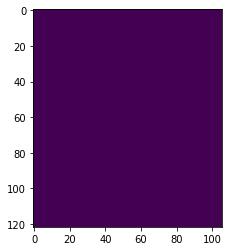

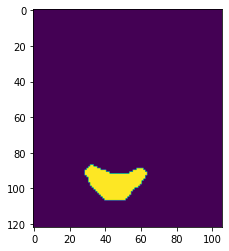

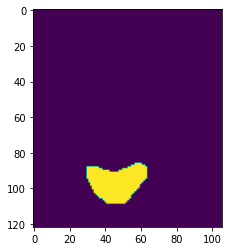

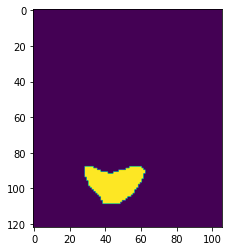

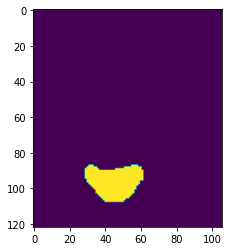

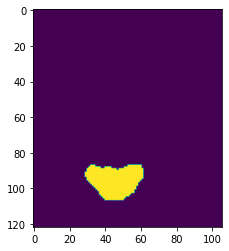

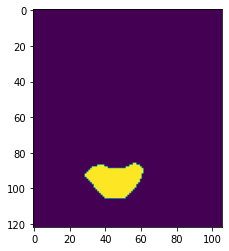

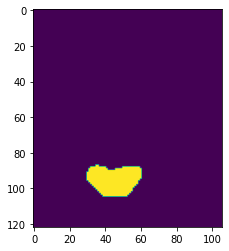

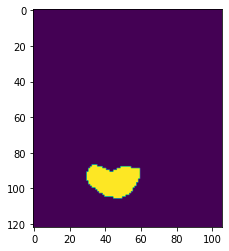

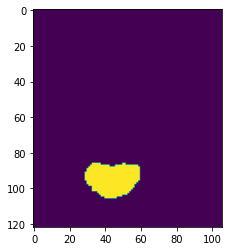

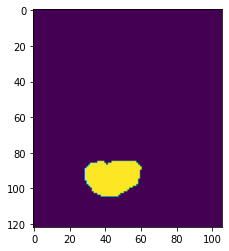

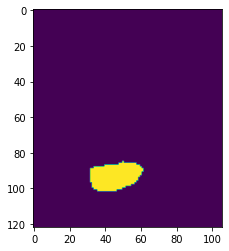

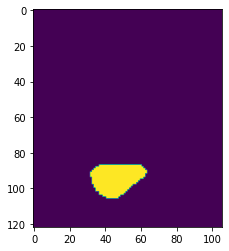

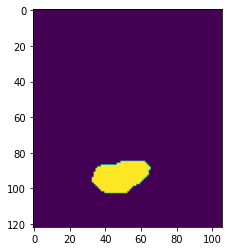

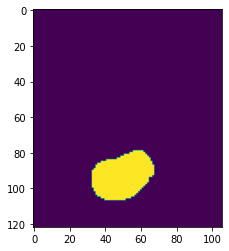

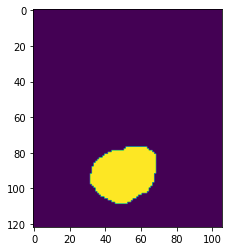

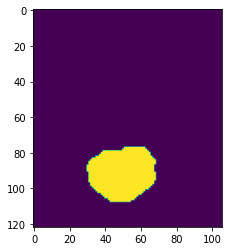

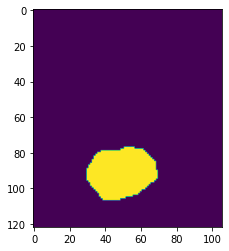

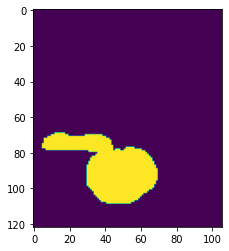

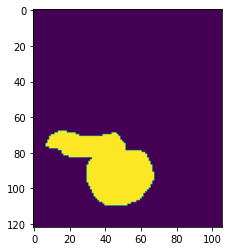

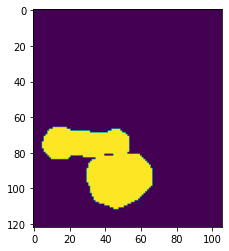

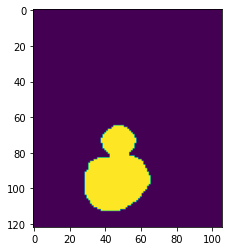

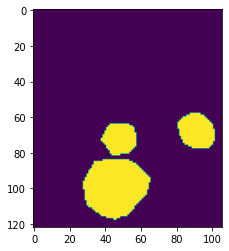

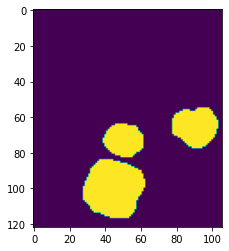

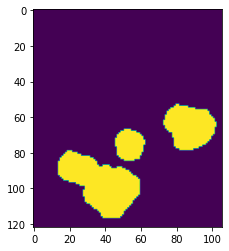

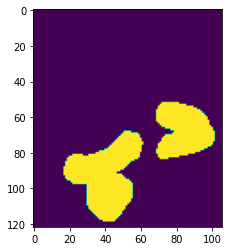

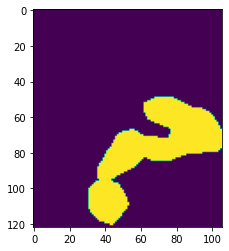

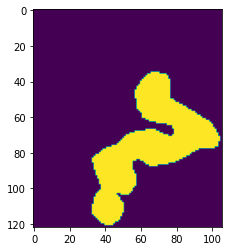

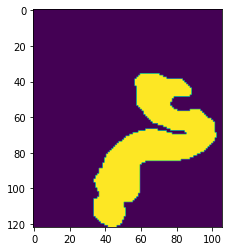

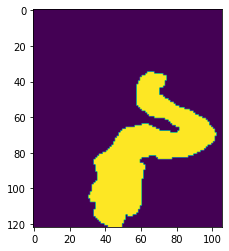

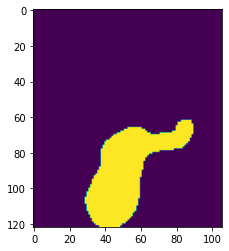

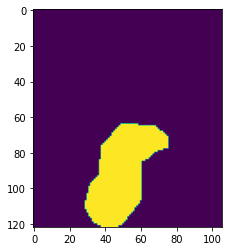

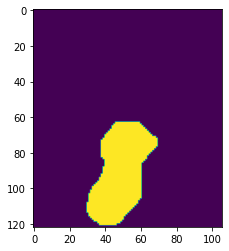

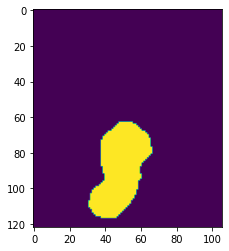

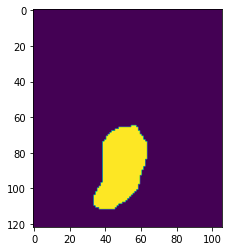

In [91]:
for z in range(imgBound["depth"]):
    timg = getImgBound(imgBound, z, True, 1, 4, d2, -10, 10)
    plt.imshow(timg)
    plt.show()

In [55]:
def resetImg(img, imgBound):
    for y in range(imgBound["y1"] - imgBound["y0"]):
        for x in range(imgBound["x1"] - imgBound["x0"]):
            if img[y][x] == -20:
                img[y][x] = 10
    return img
def setMarksInImg(img, markedImg):
    for y in range(imgBound["y1"] - imgBound["y0"]):
        for x in range(imgBound["x1"] - imgBound["x0"]):
            if markedImg[y][x] == -20:
                img[y][x] = -20
    return img

In [51]:
def findEdge(img, imgBound, vLow = -93, vHigh = 26):
    def getNeighbourImg(imgBound, arr):
        img = [ [ 0 for i in range(imgBound["x1"] - imgBound["x0"])] for j in range(imgBound["y1"] - imgBound["y0"]) ]
        for i in arr:
            try:
                img[i[1]][i[0]] = 1
            except:
                print(i, imgBound, imgBound["x0"] - imgBound["x1"], imgBound["y0"] - imgBound["y1"])
        return img
    def isNeighbour2(img, x, y, val2, imgBound):
        c = 0
        cx = 0
        cy = 0
        for ty in range(-1, 2):
            for tx in range(-1, 2):
                if x + tx >= 0 and y + ty >= 0 and x + tx < imgBound["x1"] - imgBound["x0"] and y + ty < imgBound["y1"] - imgBound["y0"] and img[y + ty][x + tx] == val2:
                    c = c + 1
                    cx = tx
                    cy = ty
                    break
        return (True, cx, cy) if c > 0 else (False, cx, cy)
    def getNeighbour(img, arr, x, y, val1, val2, imgBound):
        c = 0
        for ty in range(-1, 2):
            for tx in range(-1, 2):
                if x + tx >= 0 and y + ty >= 0 and x + tx < imgBound["x1"] - imgBound["x0"] and y + ty < imgBound["y1"] - imgBound["y0"] and img[y + ty][x + tx] == val1 and isNeighbour2(img, x + tx, y + ty, val2, imgBound)[0]:
                    arr.append((x + tx, y + ty))
                    c = c + 1
        return c
    def markPoint(img, x, y, markValue, neighVal, imgBound):
        xStart = -1 if neighVal[1] == 0 else 0
        xEnd = 1 if neighVal[1] == 0 else 2 * neighVal[1]
        xStep = 1 if neighVal[1] == 0 else neighVal[1]
        yStart = -1 if neighVal[2] == 0 else 0
        yEnd = 1 if neighVal[2] == 0 else 2 * neighVal[2]
        yStep = 1 if neighVal[2] == 0 else neighVal[2]
        # print(xStart, xEnd, xStep, yStart, yEnd, yStep, markValue)
        for ty in range(yStart, yEnd, yStep):
            for tx in range(xStart, xEnd, xStep):
                if x + tx >= 0 and y + ty >= 0 and x + tx < imgBound["x1"] - imgBound["x0"] and y + ty < imgBound["y1"] - imgBound["y0"]:
                    img[y + ty][x + tx] = markValue
    def markEdge(img, x, y, imgBound, currentVal, markValue, neighVal):
        arr = [(x, y)]
        c = 1
        while len(arr) > 0:
            f = arr.pop()
            markPoint(img, f[0],  f[1], markValue, neighVal, imgBound)
            c = c + getNeighbour(img, arr, f[0], f[1], currentVal, 10, imgBound)
            # print
            # plt.imshow(img)
            # plt.show()
            # print(img(arr[-1][1], arr[-1][0]))
            # print(img[arr[-1][1]][arr[-1][0]])
            # plt.imshow(getNeighbourImg(imgBound, arr))
            # plt.show()
            # time.sleep(2)
        return img
    for y in range(imgBound["y1"] - imgBound["y0"]):
        for x in range(imgBound["x1"] - imgBound["x0"]):
            neighVal = isNeighbour2(img, x, y, 10, imgBound)
            if img[y][x] == -10 and neighVal[0] == True:
                # print(neighVal)
                timg = markEdge(img, x, y, imgBound, -10, -20, neighVal)
                # plt.imshow(timg)
                # plt.show()
                # time.sleep(4)
                # reg = markSmallRegions(img, x, y, -10, -8, imgBound)
    return img

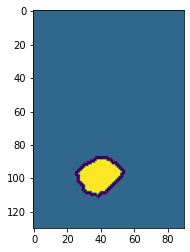

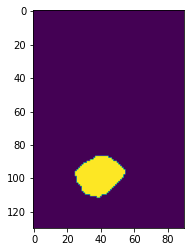

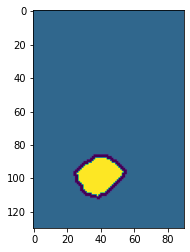

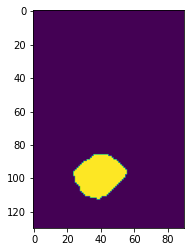

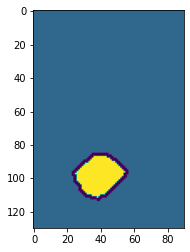

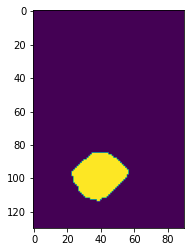

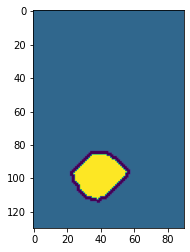

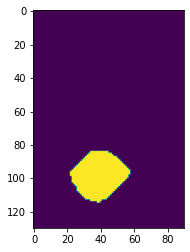

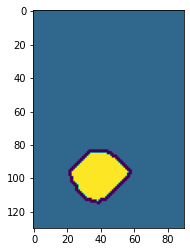

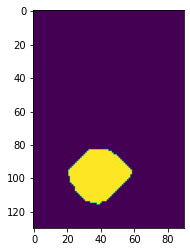

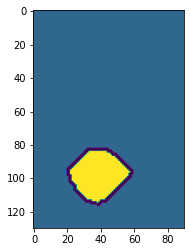

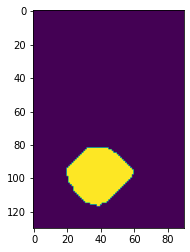

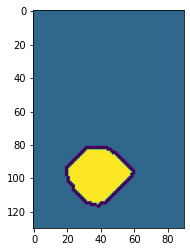

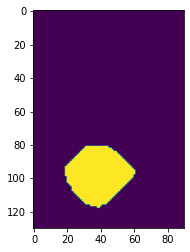

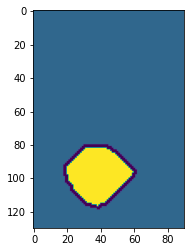

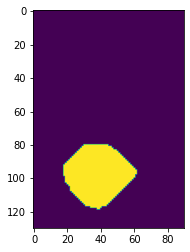

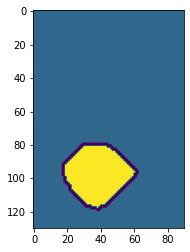

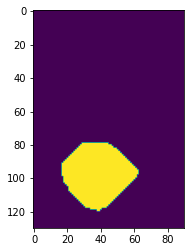

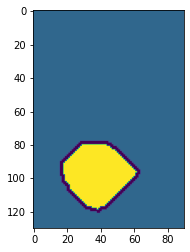

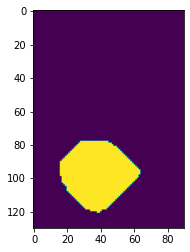

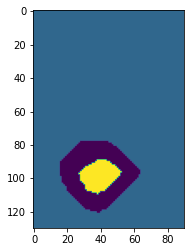

In [57]:
timg = getImgBound(imgBound, 2, True, 1, 4, d2, -10, 10)
timg2 = getImgBound(imgBound, 2, True, 1, 4, d2, -10, 10)
for i in range(10):
    timg = findEdge(timg, imgBound, 1, 4)
    plt.imshow(timg)
    plt.show()
    setMarksInImg(timg2, timg)
    plt.imshow(resetImg(timg, imgBound))
    plt.show()
plt.imshow(timg2)
plt.show()

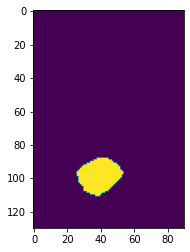

In [59]:
plt.imshow(getImgBound(imgBound, 2, True, 1, 4, d2, -10, 10))
plt.show()

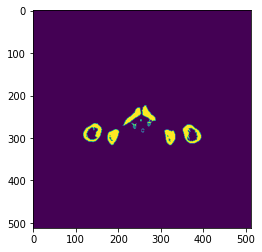

In [14]:
for z in range(10):
    plt.imshow(getImg(40))